# Introduction to Apache Spark

_Apache Spark is a fast and general engine for large-scale data processing._ Our aim here is to get ourselves a bit familiar with Spark using Python. Spark's API can also be accessed via Scala, R or Java.

__NOTE__: In this introduction we use a very small dataset. This is mainly because the machine that this was written on is not powerful enough to deal with large datasets.

## The Map Reduce programming model

_"The map function processes a key/value pair to generate a set of intermediate key/value pairs, and the reduce function merges all intermediate values associated with the same intermediate key."_

The following paper explains more or less everything that one needs to know about MapReduce: [MapReduce: Simplified Data Processing on Large Cluster](https://static.googleusercontent.com/media/research.google.com/en//archive/mapreduce-osdi04.pdf)

## Spark Context

The very first job that a Spark program does is to establish a connection to a Spark cluster. This is done by creating a [SparkContext](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.SparkContext) object. In order to create a SparkContext object, we need to specify some information about our application which is done by building a [SparkConf](http://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.SparkConf) object.

In [1]:
from pyspark import SparkConf
from pyspark import SparkContext
import os
from IPython.display import Image
from IPython.core.display import HTML
from operator import add
import nltk
from nltk.corpus import stopwords
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

%matplotlib inline
sns.set(style="darkgrid")

In [2]:
# Make Spark work on Windows
# os.environ['SPARK_HOME'] = r"C:\Users\iulian.udrea\Downloads\spark-2.2.0-bin-hadoop2.7"

In [3]:
# Initialise SparkContext
# conf = SparkConf().setAppName(APP_NAME).setMaster(MASTER_URL)
conf = SparkConf().setAppName("SSCI_study_DIP").setMaster("local[*]")
sc = SparkContext(conf=conf)
# sc = SparkContext.getOrCreate(conf=conf)

`APP_NAME` is the name of the application and `MASTER_URL` is the cluster's URL (e.g.: spark://10.193.173.68:51266).

Below is a diagram showing the relationship between the driver program, the cluster resource manager and executors:

In [4]:
Image(url="https://spark.apache.org/docs/latest/img/cluster-overview.png")

Let's go through a simple example of MapReduce. We're going to explain this in details later on but for now let's just focus on the `map` and `reduce` functions.

In [5]:
my_dict = {1: "foo", 2: "bar", 3: "baz"}
my_distributed_dict = sc.parallelize([2, 1, 3]) # this can now be operated on in parallel

In [6]:
my_distributed_dict_mapped = my_distributed_dict.map(lambda x: my_dict[x])

In [7]:
# Concatenate the strings and capitalise the result
my_distributed_dict_map_reduced = my_distributed_dict_mapped.reduce(lambda a, b: (a + b).upper())

In [8]:
# print(my_distributed_dict_map_reduced)
my_distributed_dict_map_reduced

'BARFOOBAZ'

## Resilient Distributed Datasets (RDDs)

A __resilient distributed dataset (RDD)__ represents a collection of items which are __partitioned across the nodes__ of a cluster that can be __manipulated in parallel__.

RDD objects are in one way or another similar to DataFrame objects in Pandas, in the sense that we load a dataset into an RDD and then apply any methods that are available to that object. We can __create RDDs by referencing a dataset__ in a local or an external storage system __or by parallelising an existing collection__ by calling SparkContext's parallelize method.

A nice feature that RDDs have is that they automatically __recover in case of node failures__.

Let's create a text file RDD from an external file using SparkContext's textFile method which takes the URI for the file located either on the local machine or externally (hdfs://, s3n://, ...) and reads it as a collection of lines. In the following example, we read the file from local storage.

In [9]:
sscistudy = sc.textFile("data/sscistudy.txt")

In [10]:
# print(sscistudy)
sscistudy

data/sscistudy.txt MapPartitionsRDD[3] at textFile at NativeMethodAccessorImpl.java:0

The `sscistudy.txt` file is __not loaded into memory__. sscistudy is just a __pointer__ to the sscistudy.txt file.

Another way to create RDDs, as we mentioned above, is by calling SparkContext's `parallelize` which is shown again in the next section.

## Transformations and Actions (RDD operations)

[Transformations](http://spark.apache.org/docs/latest/programming-guide.html#transformations) return pointers to new RDDs, whereas [actions](http://spark.apache.org/docs/latest/programming-guide.html#actions) return values.

In this example we are counting how many times a city appears in our list of cities.

In [11]:
cities = ["St. Petersburg", "Toronto", "St. Petersburg", "Oslo", "St. Petersburg", "Moscow", "London", "Bucharest", "St. Petersburg", "Oslo", "Bucharest", "Paris", "St. Petersburg", "Paris", "Paris"]
distributed_cities = sc.parallelize(cities, numSlices=6)

When we call ``parallelize``, there is an important parameter for parallel collections -- this is the number of __partitions__ (or slices) to cut the data into. This is done automatically by Spark (based on your cluster) but you can manually change this parameter, as shown above.

In [12]:
distributed_cities_mapped = distributed_cities.map(lambda x: (x, 1))

In [13]:
# print(distributed_cities_mapped.collect())
distributed_cities_mapped.collect()

[('St. Petersburg', 1),
 ('Toronto', 1),
 ('St. Petersburg', 1),
 ('Oslo', 1),
 ('St. Petersburg', 1),
 ('Moscow', 1),
 ('London', 1),
 ('Bucharest', 1),
 ('St. Petersburg', 1),
 ('Oslo', 1),
 ('Bucharest', 1),
 ('Paris', 1),
 ('St. Petersburg', 1),
 ('Paris', 1),
 ('Paris', 1)]

In [14]:
distributed_cities_map_reduced = distributed_cities_mapped.reduceByKey(add)

In [15]:
# We can chain operations, i.e. call multiple operations on an RDD in a single line
# print(distributed_cities_map_reduced.sortBy(lambda x: -x[1]).collect())
distributed_cities_map_reduced.sortBy(lambda x: -x[1]).collect()

[('St. Petersburg', 5),
 ('Paris', 3),
 ('Oslo', 2),
 ('Bucharest', 2),
 ('Toronto', 1),
 ('Moscow', 1),
 ('London', 1)]

## Playing with a real dataset

Let's return to our dataset (sscistudy.txt) that was loaded from the local hard drive.

I thought it would be fun to grab the (now declassified) _Senate Select Committee on Intelligence study of the CIA's Detention and Interrogation Program_ document and squeeze out some information out of it without reading it. The document (which can be found [here](https://www.amnestyusa.org/pdfs/sscistudy1.pdf) in PDF format) is 525 pages long.

In [16]:
print("Number of lines in sscistudy: %d" %sscistudy.count())

Number of lines in sscistudy: 44434


In [17]:
# Get the lengths of each line in the text file
sscistudy_line_lengths = sscistudy.map(lambda line: len(line))

In [18]:
# Sum up the lengths of each line in the text file
sscistudy_line_lengths.reduce(lambda x, y: x + y)

1872677

`count()` and `reduce()` are actions as they return actual values (the number of lines in the text file and the sum of the lengths of all the lines in the text file).

`map()` is a transformation as we used it to return a new RDD.

It's important to note that __all transformations in Spark are lazy__, in the sense that they do not compute anything unless they need to. In other words, transformations are computed when an action needs a result to be returned to the driver program.

We can recompute each transformed RDD as many times as we want but it would be much more efficient if we __persist an RDD in memory__ by using the `persist` (or cache) method which allows it to be reused across parallel operations. That is, if we wanted to perform an action on sscistudy_line_lengths and keep the value in memory for later use, we could do the following:

In [19]:
sscistudy_line_lengths.persist()

PythonRDD[19] at RDD at PythonRDD.scala:48

Doing this, Spark will keep the items on the cluster for faster access when we next query them.

In [20]:
# We can also use the 'takeSample()' action
sscistudy_sample = sscistudy.sample(withReplacement=False, fraction=0.01, seed=1235)

In [21]:
# print(sscistudy_sample.collect())
sscistudy_sample.collect()

['Department of State, and the Office of the Director of National Intelligence in the',
 'I began my service on the Senate Intelligence Committee in January 2001. I',
 '',
 'President Obama signed Executive Order 13491 in January 2009 to prohibit the',
 'written thousands of its pages, and has been integrallyinvolved in every Study',
 'acquiring intelligence or gaining cooperation from detainees.',
 '',
 '',
 '',
 '',
 'techniques on detainees, and (4) the effectiveness of the techniques. Those representations were',
 'III!',
 'provide proper leadership and management, were also not held to account.',
 'that mistakes should be expected in a business filled with uncertainty," and "the Director',
 'was forced to relocate detainees out of every country in which it established a detention facility',
 '',
 'Legal Defensefor Using Techniques Considered Torture; the CIA Conducts No Research on Effective',
 '6.',
 'C.',
 'Death ofGul Rahman Leads CIA Headquarters to Leam of UnreportedCoercive 

### Let's do a bit of Natural Language Processing

Upper-case and lower-case words are counted separately, and thus turning every word to lower-case letters will solve this problem. Let's also remove punctuation.

We can of course do more processing but that's not the point here. The interested reader can go ahead and clean the text as much as they want to.

In [22]:
def cleanupText(s):
    return(re.sub("[^a-zA-Z0-9\s]+","", s).lower().strip())

Explanation of the regular expression above:

* []: any of the following

* ^: anything that doesn't contain

* a-z; A-Z; 0-9: self-explanatory

* \s: whitespace

* +: one or more of the preceding token

Let's do a quick check and see if this ``cleanupText`` function does what we want.

In [23]:
my_string = "Mercury is my favourite planet! Why? Because of its orbit around the sun! D'oh! Mercury... oh yes! Mercury!"

In [24]:
cleanupText(my_string)

'mercury is my favourite planet why because of its orbit around the sun doh mercury oh yes mercury'

In [25]:
sscistudy_list = sscistudy.map(cleanupText)

In [26]:
# print(sscistudy_list.take(200)[150:])
sscistudy_list.take(200)[150:]

['never again allow for secret indefinite detention and the use of coercive',
 '',
 'interrogations as the study describes prior to the attacks of september 2001 the',
 'cia itself determined from its own experience with coercive interrogations that',
 'such techniques do not produce intelligence will probably result in false',
 'answers and had historically proven to be ineffective yet these conclusions',
 '',
 'were ignored we cannot again allow history to be forgotten and grievous past',
 'mistakes to be repeated',
 '',
 'page 3 of 6',
 'unclassified',
 '',
 'unclassified',
 '',
 'president obama signed executive order 13491 in january 2009 to prohibit the',
 'cia from holding detainees other than on a shortterm transitory basis and to',
 'limit interrogation techniques to those includedin the army field manual',
 'however these limitations are not part of us law and could be overturned by a',
 'future president with the stroke of a pen they should be enshrined in legislation',
 'ev

In [27]:
# Split each element of the RDD by its spaces.
sscistudy_words = sscistudy_list.flatMap(lambda x: x.split(" "))

In [28]:
# print(sscistudy_words.take(200)[150:])
sscistudy_words.take(200)[150:]

['2007',
 '',
 'the',
 'full',
 'committee',
 'study',
 'which',
 'totals',
 'more',
 'than',
 '6700',
 'pages',
 'remains',
 'classified',
 'but',
 'is',
 'now',
 'an',
 'official',
 'senate',
 'report',
 'the',
 'full',
 'report',
 'has',
 'been',
 'provided',
 'to',
 'the',
 'white',
 'house',
 'the',
 'cia',
 'the',
 'department',
 'of',
 'justice',
 'the',
 'department',
 'of',
 'defense',
 'the',
 '',
 'department',
 'of',
 'state',
 'and',
 'the',
 'office',
 'of']

We notice that we have some empty elements and they don't add anything of importance to our analysis so let's get rid of them.

In [29]:
# Keep all the non-empty elements
sscistudy_words_nospaces = sscistudy_words.filter(lambda x: len(x) != 0)

Creating word pairs helps us with counting the frequency of words, so let's do that.

In [30]:
sscistudy_word_pairs = sscistudy_words_nospaces.map(lambda x: (x, 1))

In [31]:
# print(sscistudy_word_pairs.take(25))
sscistudy_word_pairs.take(25)

[('classified', 1),
 ('nofqrn', 1),
 ('top', 1),
 ('secret', 1),
 ('senate', 1),
 ('select', 1),
 ('comiiiittee', 1),
 ('on', 1),
 ('infelligeoee', 1),
 ('committee', 1),
 ('study', 1),
 ('ofthe', 1),
 ('centralintelligence', 1),
 ('agmcy', 1),
 ('s', 1),
 ('detention', 1),
 ('and', 1),
 ('interrogation', 1),
 ('program', 1),
 ('sbg53', 1),
 ('foreword', 1),
 ('by', 1),
 ('senate', 1),
 ('select', 1),
 ('committee', 1)]

We use the `reduceByKey()` transformation to count the frequency of words.

In [32]:
sscistudy_word_count = sscistudy_word_pairs.reduceByKey(lambda x, y: x + y)

In [33]:
# print(sscistudy_word_count.take(30))
sscistudy_word_count.take(30)

[('secret', 464),
 ('select', 186),
 ('comiiiittee', 1),
 ('infelligeoee', 1),
 ('centralintelligence', 3),
 ('s', 57),
 ('chairman', 105),
 ('bianne', 1),
 ('findings', 25),
 ('executive', 58),
 ('approved', 94),
 ('132012', 2),
 ('april', 421),
 ('2014', 10),
 ('revisions', 3),
 ('ml', 10),
 ('4', 222),
 ('voted', 5),
 ('send', 14),
 ('of', 8751),
 ('subsequent', 59),
 ('public', 86),
 ('this', 1042),
 ('action', 54),
 ('decision', 53),
 ('in', 5092),
 ('but', 293),
 ('an', 931),
 ('investigation', 122),
 ('into', 151)]

Let's clean up our text a tad more using the NLP library `nltk`.

In [34]:
nltk.download("stopwords")
stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/iulian/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [35]:
# Keep all the words that are not stop words. Remember that 'x' is actually a pair: (word, count)
sscistudy_word_count = sscistudy_word_count.filter(lambda x: x[0] not in stopwords)

In [36]:
word_count_top20 = sscistudy_word_count.takeOrdered(20, lambda x: -x[1])

In [37]:
# print(word_count_top20)
word_count_top20

[('cia', 6109),
 ('interrogation', 2510),
 ('cias', 1891),
 ('techniques', 1764),
 ('abu', 1683),
 ('information', 1663),
 ('redacted', 1464),
 ('intelligence', 1426),
 ('detention', 1274),
 ('see', 1273),
 ('enhanced', 1265),
 ('2003', 1107),
 ('program', 1078),
 ('unclassified', 1058),
 ('detainees', 1021),
 ('ksm', 992),
 ('provided', 849),
 ('zubaydah', 844),
 ('use', 843),
 ('general', 831)]

This isn't a surprise that CIA is the most frequent word in this document. What's interesting is that the word "Abu" is the 5th most frequent word. It turns out that Abu Zubaydah is a CIA detainee.

### Visualising our results

In [38]:
most_common_words = [word[0] for word in word_count_top20]
most_common_count = [count[1] for count in word_count_top20]

In [39]:
sscistudy_words_frequency = {'word': most_common_words, 'frequency': most_common_count}

In [40]:
df = pd.DataFrame(sscistudy_words_frequency)
# df.head()

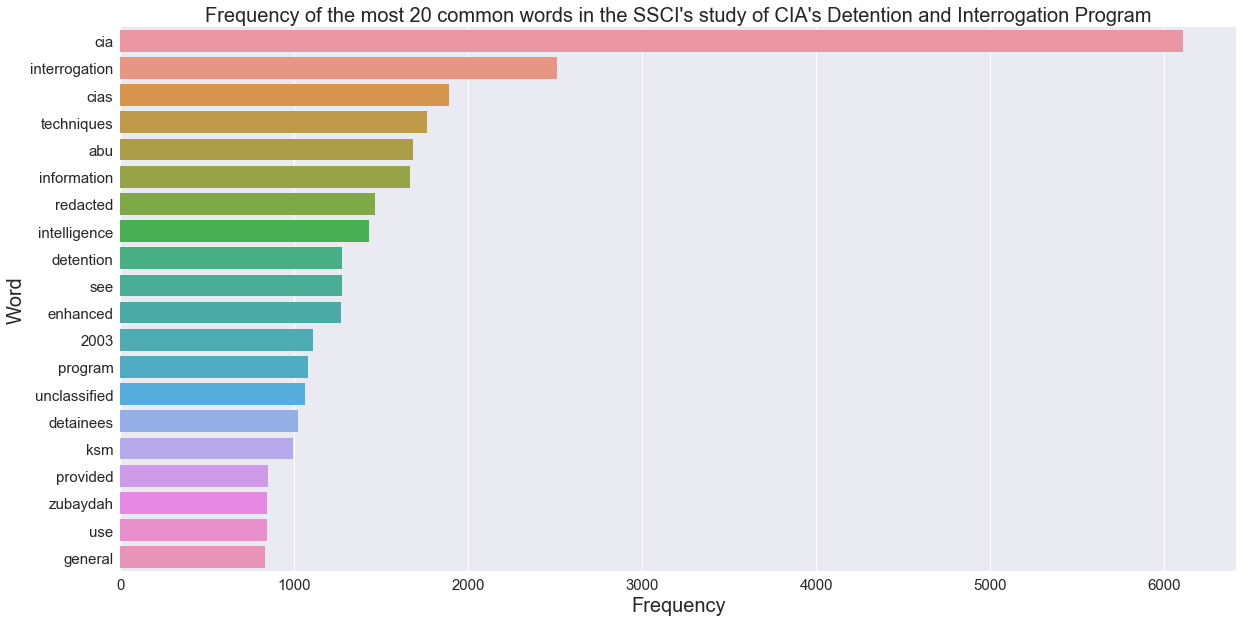

In [41]:
# Chart the words against their corresponding frequencies
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(data=df, x='frequency', y='word')
# ax.set(xlabel="Frequency", ylabel="Word", title="Frequency of the most 20 common words")
ax.set_xlabel("Frequency", fontsize=20)
ax.set_ylabel("Word", fontsize=20)
ax.set_title("Frequency of the most 20 common words in the SSCI's study of CIA's Detention and Interrogation Program", fontsize=20)
ax.tick_params(labelsize=15)

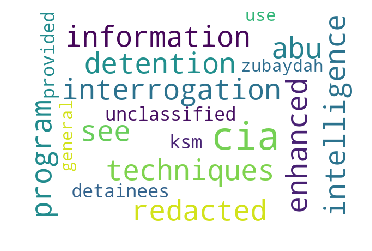

In [42]:
word_cloud = WordCloud(width=600, height=400, background_color="white", max_font_size=70, relative_scaling=0.5)
word_cloud.generate(' '.join(df['word']))
plt.figure()
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

## Monitoring Spark applications

Spark comes with a web UI (or to be more precise, it's the driver program that has a web UI). If you're running Spark locally, then going to http://localhost:4040/ will take you to the user interface. If you're not running Spark locally, then replace localhost with the address of the driver's node.